In [22]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import sys
import os

proj_dir = os.environ['CMS_ROOT']
sys.path.append(proj_dir)
from utils.utils import args_to_dict, write_perf_metrics, Timer
from utils.utils import get_best_threshold, get_imbalance_description
from utils.data import load_data, get_train_test, df_to_csr

## Config

In [23]:
debug = False
runs = 1
embedding_type = 'onehot'
sample_size = 5000000
n_jobs = 8
max_depth = 8
n_estimators = 5 if debug else 100

print(f'Using n_estimators: {n_estimators}')

Using n_estimators: 100


## Load Data

In [24]:
data = load_data(sample_size)
print(f'Loaded data with shape {data.shape}')

# create train-test split
with_hcpcs = embedding_type == 'onehot'
with_categorical = embedding_type == 'categorical'

print(f'with_hcpcs: {with_hcpcs}, with_categorical: {with_categorical}')

Loaded data with shape (5000000, 13)
with_hcpcs: True, with_categorical: False


## Train Test Split + One Hot Encoding

In [27]:
data.columns

Index(['index', 'npi', 'provider_type', 'nppes_provider_state',
       'nppes_provider_gender', 'hcpcs_code', 'line_srvc_cnt',
       'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_submitted_chrg_amt',
       'average_medicare_payment_amt', 'year', 'exclusion'],
      dtype='object')

In [28]:
y = data['exclusion']

df = data.drop(columns=['index', 'npi', 'year', 'exclusion', 'hcpcs_code'])

train_ind, test_ind = train_test_split(
    np.arange(0, df.shape[0], 1), test_size=0.2, random_state=42)

df = pd.get_dummies(df, sparse=True)
# keep reference to the columns, will need these
columns = df.columns
df = df_to_csr(df)
train_x = df[train_ind]
test_x = df[test_ind]
train_y = y[train_ind]
test_y = y[test_ind]

print(f'Train shape {train_x.shape}, Test shape {test_x.shape}')
print(f'Training class imbalance description:\n{get_imbalance_description(train_y)}')

/Users/jujohnson/git/HCPCS-Embeddings-For-Fraud-Detection/utils/data.py:36: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  df = df.to_sparse().to_coo().astype('float32')
/Users/jujohnson/anaconda3/envs/tf.latest/lib/python3.6/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


Train shape (4000000, 159), Test shape (1000000, 159)
Training class imbalance description:
Negative Samples: 3996585
Positive Samples: 3415
Postive Class Ratio: 0.085375


In [31]:
%%time

model = XGBClassifier(
    n_jobs=-1,
    n_estimators=n_estimators,
    max_depth=max_depth,
    feature_names=columns)
model.fit(train_x, train_y)

CPU times: user 1h 1min 30s, sys: 19.9 s, total: 1h 1min 50s
Wall time: 6min 5s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt',
       'average_submitted_chrg_amt', 'average_medicare_payment_amt',
       'provider_type_Addiction Medicine', 'provider_type_All Other Suppliers',
       'provider_type_Allergy/Immunology',
       'provide...
       'nppes_provider_state_XX', 'nppes_provider_state_ZZ',
       'nppes_provider_gender_F', 'nppes_provider_gender_M'],
      dtype='object', length=159),
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
train_y_prob = model.predict_proba(train_x)[:, 1]
test_y_prob = model.predict_proba(test_x)[:, 1]
print(f'Train AUC: {roc_auc_score(train_y, train_y_prob)}')
print(f'Test AUC: {roc_auc_score(test_y, test_y_prob)}')

Train AUC: 0.9058035750804094
Test AUC: 0.8775809537175666


## Feature Importance

In [33]:
feature_imp = pd.DataFrame(zip(columns, model.feature_importances_), columns=['feature', 'importance'])

In [34]:
feature_imp.sort_values(by='importance', ascending=False).head(25)

,feature,importance
26,provider_type_Diagnostic Radiology,0.054581
158,nppes_provider_gender_M,0.029554
63,provider_type_Orthopedic Surgery,0.027197
129,nppes_provider_state_NC,0.026922
12,provider_type_Audiologist (billing independently),0.026037
116,nppes_provider_state_IN,0.022571
145,nppes_provider_state_TN,0.022203
151,nppes_provider_state_WA,0.021698
67,provider_type_Pathology,0.021457
153,nppes_provider_state_WV,0.021274


In [35]:
features = feature_imp['feature']

In [36]:
mask = (features.str.contains('provider_type')) | (features.str.contains('hcpcs') | (features.str.contains('state')))

In [37]:
feature_imp.loc[~mask]

,feature,importance
0,line_srvc_cnt,0.002872
1,bene_unique_cnt,0.002769
2,bene_day_srvc_cnt,0.002812
3,average_submitted_chrg_amt,0.003009
4,average_medicare_payment_amt,0.002375
157,nppes_provider_gender_F,0.002301
158,nppes_provider_gender_M,0.029554


In [12]:
model.save_model('model.xgb')

In [38]:
cumm_importance = {
  'state': 0,
  'provider_type': 0,
  'hcpcs': 0,
  'gender': 0,
  'line_srvc_cnt': 0,
  'bene_unique_cnt': 0,
  'bene_day_srvc_cnt': 0,
  'average_submitted_chrg_amt': 0,
  'average_medicare_payment_amt': 0,
}

In [39]:
for idx, row in feature_imp.iterrows():
  feature, score = row['feature'], row['importance']
  if 'provider_type' in feature:
    cumm_importance['provider_type'] += score
  elif 'state' in feature:
    cumm_importance['state'] += score
  elif 'hcpcs' in feature:
    cumm_importance['hcpcs'] += score
  elif 'gender' in feature:
    cumm_importance['gender'] += score
  else:
    cumm_importance[feature] += score

In [40]:
pd.DataFrame(cumm_importance.values(), index=cumm_importance.keys()).sort_values(by=0, ascending=False)

,0
provider_type,0.530613
state,0.423695
gender,0.031854
average_submitted_chrg_amt,0.003009
line_srvc_cnt,0.002872
bene_day_srvc_cnt,0.002812
bene_unique_cnt,0.002769
average_medicare_payment_amt,0.002375
hcpcs,0.000000


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['ggplot', 'seaborn-poster'])

[Text(0, 0, 'state'),
 Text(0, 0, 'provider_type'),
 Text(0, 0, 'hcpcs'),
 Text(0, 0, 'gender'),
 Text(0, 0, 'line_srvc_cnt'),
 Text(0, 0, 'bene_unique_cnt'),
 Text(0, 0, 'bene_day_srvc_cnt'),
 Text(0, 0, 'average_submitted_chrg_amt'),
 Text(0, 0, 'average_medicare_payment_amt')]

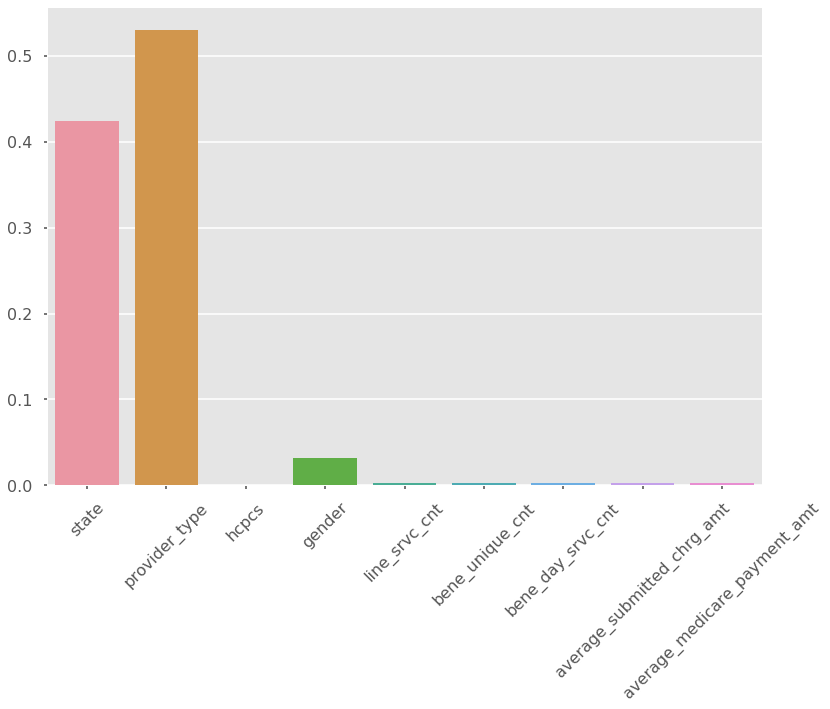

In [42]:
chart = sns.barplot(x=list(cumm_importance.keys()), y=list(cumm_importance.values()))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [43]:
chart.figure.savefig('feature-importance-without-hcpcs.png')